In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import sys
import seaborn as sns
import matplotlib.pyplot as plt

# not great, temp fix? ask jorge
sys.path.append("../../../../")
sys.path.append("../../../")

from data_pipeline.score import field_names
from data_pipeline.comparison_tool.src import utils

pd.options.display.float_format = "{:,.3f}".format
%load_ext lab_black

# Comparator definition comparison

This notebook answers a few questions:
1. How many tracts are flagged and what's the size of overlap by comparator?
2. What are the demographics of each set of tracts by "category" of score (CEJST but not comparator, comparator but not CEJST, CEJST and comparator)?
3. What are the overall demographics of ALL comparator vs ALL CEJST?

It produces a single Excel file of the stats listed, but is interactive even after run-time. This notebook focuses on 1:1 comparison. It can be pointed in the YAML to either a simple output (tract and boolean for highlight) or to the output from an ETL.

In [2]:
## These are parameters and get overridden by the "injected parameters" cell below
ADDITIONAL_DEMO_COLUMNS = []
COMPARATOR_COLUMN = None
COMPARATOR_FILE = None
DEMOGRAPHIC_COLUMNS = []
DEMOGRAPHIC_FILE = None
OUTPUT_DATA_PATH = None
SCORE_FILE = None
OTHER_COMPARATOR_COLUMNS = None
OUTPUT_NAME = None

In [20]:
# Parameters
ADDITIONAL_DEMO_COLUMNS = [
    "Urban Heuristic Flag",
    "Percent of individuals below 200% Federal Poverty Line",
    "Percent individuals age 25 or over with less than high school degree",
    "Unemployment (percent)",
    "Percent of households in linguistic isolation",
]
COMPARATOR_COLUMN = "donut_hole_dac_additional_constraints"
COMPARATOR_FILE = "/Users/emmausds/Desktop/justice40-tool/data/data-pipeline/data_pipeline/comparison_tool/data/donut_hole_dac/donut_hole_data.csv"
DEMOGRAPHIC_COLUMNS = [
    "Percent Black or African American alone",
    "Percent American Indian and Alaska Native alone",
    "Percent Asian alone",
    "Percent Native Hawaiian and Other Pacific alone",
    "Percent Two or more races",
    "Percent Non-Hispanic White",
    "Percent Hispanic or Latino",
]
DEMOGRAPHIC_FILE = "/Users/emmausds/Desktop/justice40-tool/data/data-pipeline/data_pipeline/data/dataset/census_acs_2019/usa.csv"
OUTPUT_DATA_PATH = "/Users/emmausds/Desktop/justice40-tool/data/data-pipeline/data_pipeline/comparison_tool/output/donut_hole_dac"
SCORE_FILE = "/Users/emmausds/Desktop/justice40-tool/data/data-pipeline/data_pipeline/data/score/csv/full/usa.csv"
OTHER_COMPARATOR_COLUMNS = [
    "donut_hole_dac",
    "P200_PFS",
    "HSEF",
    "mean_neighbor_score_updated",
]
OUTPUT_NAME = "donut_hole_dac"

In [21]:
## These are constants for all runs
GEOID_COLUMN = field_names.GEOID_TRACT_FIELD
SCORE_COLUMN = field_names.SCORE_M_COMMUNITIES
TOTAL_POPULATION_COLUMN = field_names.TOTAL_POP_FIELD

__Date and time of last run__

In [22]:
datetime.datetime.now()

datetime.datetime(2022, 3, 14, 21, 51, 36, 815499)

__Congfigure output (autocreated)__

In [23]:
OUTPUT_EXCEL = os.path.join(
    OUTPUT_DATA_PATH,
    f"{OUTPUT_NAME}__{datetime.datetime.now().strftime('%Y-%m-%d')}.xlsx",
)

__Read in data__

In [24]:
comparator_cols = (
    [COMPARATOR_COLUMN] + OTHER_COMPARATOR_COLUMNS
    if OTHER_COMPARATOR_COLUMNS
    else [COMPARATOR_COLUMN]
)

# papermill_description=Loading_data
joined_frame = pd.concat(
    [
        utils.read_file(
            SCORE_FILE,
            columns=[TOTAL_POPULATION_COLUMN, SCORE_COLUMN] + ADDITIONAL_DEMO_COLUMNS,
            geoid=GEOID_COLUMN,
        ),
        utils.read_file(COMPARATOR_FILE, columns=comparator_cols, geoid=GEOID_COLUMN),
        utils.read_file(
            DEMOGRAPHIC_FILE,
            DEMOGRAPHIC_COLUMNS,
            geoid=GEOID_COLUMN,
        ),
    ],
    axis=1,
).reset_index()

# Comparator may provide simple list of tracts; this will fill all census tracts with "False"
joined_frame = joined_frame.fillna({COMPARATOR_COLUMN: False, SCORE_COLUMN: False})

## High-level summary

What *shares* of tracts and population highlighted by the comparator are covered by CEJST?

In [25]:
# papermill_description=Summary_stats
population = utils.produce_summary_stats(
    joined_frame, COMPARATOR_COLUMN, SCORE_COLUMN, TOTAL_POPULATION_COLUMN, GEOID_COLUMN
)
population

Population  \
donut_hole_dac_additional_constraints Definition M (communities)                   
False                                 False                      231,012,760.000   
                                      True                        93,499,009.000   
True                                  False                        1,778,202.000   

                                                                  Count of tracts  \
donut_hole_dac_additional_constraints Definition M (communities)                    
False                                 False                                 50196   
                                      True                                  23477   
True                                  False                                   487   

                                                                  Share of tracts  \
donut_hole_dac_additional_constraints Definition M (communities)                    
False                                 False                                 0.677   
                                      True                                  0.317   
True                                  False                                 0.007   

                                                                  Share of population  
donut_hole_dac_additional_constraints Definition M (communities)                       
False                                 False                                     0.708  
                                      True                                      0.287  
True                                  False                                     0.005

## Tract-level stats

First, this walks through overall stats for disadvantaged communities under the comparator definition and under the CEJST's definition. Next, this walks through stats by group (e.g., CEJST and not comparator). This is at the tract level, so the average across tracts, where tracts are not population-weighted. 

In [26]:
# papermill_description=Tract_stats
tract_level_by_identification = pd.concat(
    [
        utils.get_demo_series(
            COMPARATOR_COLUMN,
            joined_frame,
            ADDITIONAL_DEMO_COLUMNS + DEMOGRAPHIC_COLUMNS,
        ),
        utils.get_demo_series(
            SCORE_COLUMN, joined_frame, ADDITIONAL_DEMO_COLUMNS + DEMOGRAPHIC_COLUMNS
        ),
    ],
    axis=1,
)

tract_level_by_identification

,donut_hole_dac_additional_constraints,Definition M (communities)
Urban Heuristic Flag,0.710,0.839
Percent of individuals below 200% Federal Poverty Line,0.395,0.530
Percent individuals age 25 or over with less than high school degree,0.158,0.225
Unemployment (percent),0.070,0.091
Percent of households in linguistic isolation,0.052,0.112
Percent Black or African American alone,0.243,0.250
Percent American Indian and Alaska Native alone,0.019,0.016
Percent Asian alone,0.026,0.040
Percent Native Hawaiian and Other Pacific alone,0.002,0.002
Percent Two or more races,0.030,0.034


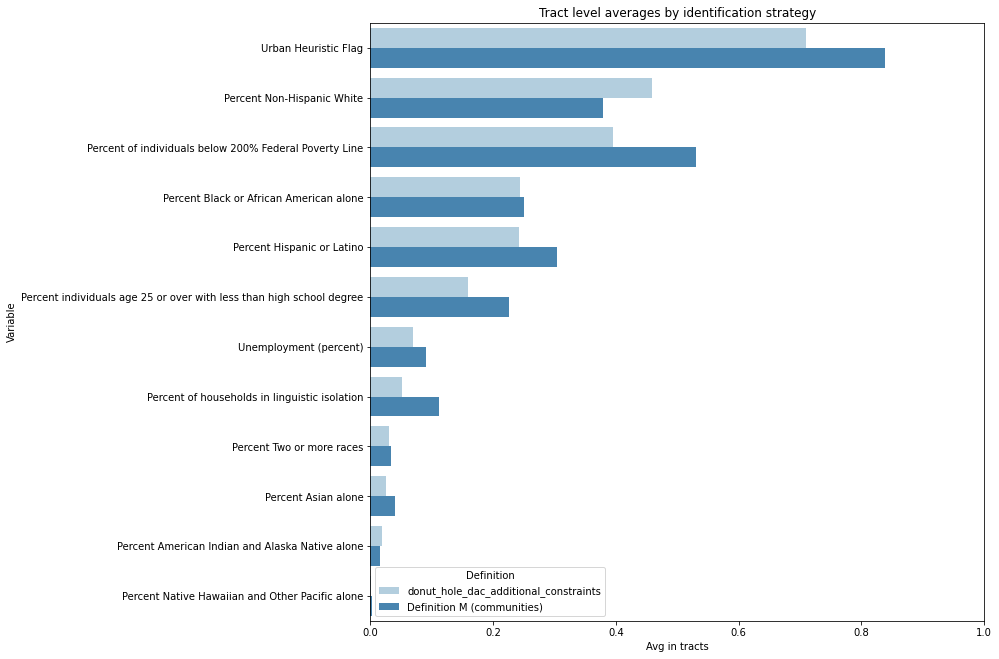

In [27]:
plt.figure(figsize=(11, 11))
sns.barplot(
    y="Variable",
    x="Avg in tracts",
    hue="Definition",
    data=tract_level_by_identification.sort_values(
        by=COMPARATOR_COLUMN, ascending=False
    )
    .stack()
    .reset_index()
    .rename(
        columns={"level_0": "Variable", "level_1": "Definition", 0: "Avg in tracts"}
    ),
    palette="Blues",
)
plt.xlim(0, 1)
plt.title("Tract level averages by identification strategy")
plt.savefig(os.path.join(OUTPUT_DATA_PATH, "tract_lvl_avg.jpg"), bbox_inches="tight")

In [28]:
# papermill_description=Tract_stats_grouped
tract_level_by_grouping = utils.get_tract_level_grouping(
    joined_frame,
    SCORE_COLUMN,
    COMPARATOR_COLUMN,
    ADDITIONAL_DEMO_COLUMNS + DEMOGRAPHIC_COLUMNS,
)

tract_level_by_grouping_formatted = utils.format_multi_index_for_excel(
    tract_level_by_grouping
)

In [29]:
tract_level_by_grouping_formatted

,Variable,"Not CEJST, Comparator","CEJST, Not Comparator"
0,Urban Heuristic Flag,0.710,0.839
1,Percent of individuals below 200% Federal Pove...,0.395,0.530
2,Percent individuals age 25 or over with less t...,0.158,0.225
3,Unemployment (percent),0.070,0.091
4,Percent of households in linguistic isolation,0.052,0.112
5,Percent Black or African American alone,0.243,0.250
6,Percent American Indian and Alaska Native alone,0.019,0.016
7,Percent Asian alone,0.026,0.040
8,Percent Native Hawaiian and Other Pacific alone,0.002,0.002
9,Percent Two or more races,0.030,0.034


## Population-weighted stats

In [30]:
# papermill_description=Population_stats
population_weighted_stats = pd.concat(
    [
        utils.construct_weighted_statistics(
            joined_frame,
            COMPARATOR_COLUMN,
            DEMOGRAPHIC_COLUMNS + ADDITIONAL_DEMO_COLUMNS,
            TOTAL_POPULATION_COLUMN,
        ),
        utils.construct_weighted_statistics(
            joined_frame,
            SCORE_COLUMN,
            DEMOGRAPHIC_COLUMNS + ADDITIONAL_DEMO_COLUMNS,
            TOTAL_POPULATION_COLUMN,
        ),
    ],
    axis=1,
)

In [31]:
population_weighted_stats

,not donut_hole_dac_additional_constraints,donut_hole_dac_additional_constraints,not Definition M (communities),Definition M (communities)
Percent Black or African American alone,0.127,0.226,0.089,0.223
Percent American Indian and Alaska Native alone,0.008,0.017,0.006,0.015
Percent Asian alone,0.055,0.028,0.059,0.044
Percent Native Hawaiian and Other Pacific alone,0.002,0.001,0.002,0.002
Percent Two or more races,0.033,0.029,0.033,0.034
Percent Non-Hispanic White,0.602,0.432,0.696,0.362
Percent Hispanic or Latino,0.188,0.286,0.126,0.345
Urban Heuristic Flag,0.821,0.699,0.819,0.823
Percent of individuals below 200% Federal Poverty Line,0.315,0.387,0.233,0.520
Percent individuals age 25 or over with less than high school degree,0.125,0.167,0.082,0.232


## Print to excel

In [32]:
# papermill_description=Writing_excel
utils.write_single_comparison_excel(
    OUTPUT_EXCEL,
    population,
    tract_level_by_identification,
    population_weighted_stats,
    tract_level_by_grouping_formatted,
)

## Additional analysis

In [33]:
joined_frame[joined_frame["donut_hole_dac_additional_constraints"]][
    "Percent of individuals below 200% Federal Poverty Line"
].isna().value_counts()

False    431
True      56
Name: Percent of individuals below 200% Federal Poverty Line, dtype: int64

In [34]:
(
    joined_frame[joined_frame["donut_hole_dac_additional_constraints"]][
        "P200_PFS"
    ].fillna(1)
    >= 0.65
).value_counts()

False    310
True     177
Name: P200_PFS, dtype: int64

# Comparing three options

In [61]:
joined_frame["cutoff_75_pct"] = (
    joined_frame["mean_neighbor_score_updated"] >= 0.75
) & (joined_frame["P200_PFS"].fillna(1) >= 0.6)

joined_frame["cutoff_85_pct"] = (
    joined_frame["mean_neighbor_score_updated"] >= 0.85
) & (joined_frame["P200_PFS"].fillna(1) >= 0.5)

In [62]:
comparison = pd.DataFrame()

In [63]:
comparison["75_cutoff"] = (
    joined_frame.groupby("cutoff_75_pct")[DEMOGRAPHIC_COLUMNS + ADDITIONAL_DEMO_COLUMNS]
    .mean()
    .loc[True]
    .T
)

comparison["85_cutoff"] = (
    joined_frame.groupby("cutoff_85_pct")[DEMOGRAPHIC_COLUMNS + ADDITIONAL_DEMO_COLUMNS]
    .mean()
    .loc[True]
    .T
)

comparison["dac_additional_cutoff"] = (
    joined_frame.groupby("donut_hole_dac_additional_constraints")[
        DEMOGRAPHIC_COLUMNS + ADDITIONAL_DEMO_COLUMNS
    ]
    .mean()
    .loc[True]
    .T
)

In [64]:
joined_frame[
    ["cutoff_75_pct", "cutoff_85_pct", "donut_hole_dac_additional_constraints"]
].sum()

cutoff_75_pct                            656
cutoff_85_pct                            444
donut_hole_dac_additional_constraints    487
dtype: int64

In [68]:
comparison.loc[ADDITIONAL_DEMO_COLUMNS]

,75_cutoff,85_cutoff,dac_additional_cutoff
Urban Heuristic Flag,0.732,0.706,0.710
Percent of individuals below 200% Federal Poverty Line,0.454,0.415,0.395
Percent individuals age 25 or over with less than high school degree,0.176,0.171,0.158
Unemployment (percent),0.073,0.072,0.070
Percent of households in linguistic isolation,0.050,0.051,0.052


In [69]:
demo_comp = pd.concat(
    [
        utils.construct_weighted_statistics(
            joined_frame,
            "cutoff_85_pct",
            DEMOGRAPHIC_COLUMNS + ADDITIONAL_DEMO_COLUMNS,
            TOTAL_POPULATION_COLUMN,
        ),
        utils.construct_weighted_statistics(
            joined_frame,
            "cutoff_75_pct",
            DEMOGRAPHIC_COLUMNS + ADDITIONAL_DEMO_COLUMNS,
            TOTAL_POPULATION_COLUMN,
        ),
        population_weighted_stats,
    ],
    axis=1,
)[
    [
        "cutoff_85_pct",
        "cutoff_75_pct",
        "donut_hole_dac_additional_constraints",
        "Definition M (communities)",
    ]
]

demo_comp.loc[ADDITIONAL_DEMO_COLUMNS]

,cutoff_85_pct,cutoff_75_pct,donut_hole_dac_additional_constraints,Definition M (communities)
Urban Heuristic Flag,0.699,0.714,0.699,0.823
Percent of individuals below 200% Federal Poverty Line,0.399,0.436,0.387,0.520
Percent individuals age 25 or over with less than high school degree,0.178,0.182,0.167,0.232
Unemployment (percent),0.066,0.068,0.066,0.086
Percent of households in linguistic isolation,0.062,0.058,0.063,0.124


<AxesSubplot:xlabel='pop avg', ylabel='Demo'>

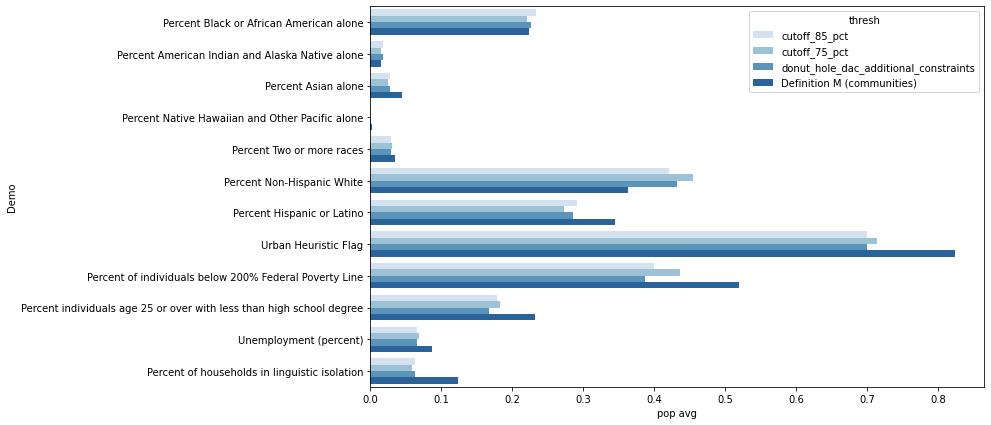

In [67]:
plt.figure(figsize=(11, 7))
sns.barplot(
    x="pop avg",
    y="Demo",
    hue="thresh",
    data=demo_comp.stack()
    .reset_index()
    .rename(columns={"level_0": "Demo", "level_1": "thresh", 0: "pop avg"}),
    palette="Blues",
)

I think this is all roughly comparable. I would argue for the narrowest definition that passes scrutiny - low income (below 50th percentile) and 85% of neighbors. I am also open to looking at income OR high school attainment rate. I think from the perspective of administering benefits, this will get veeeery tricky. 